<a href="https://colab.research.google.com/github/gdecugis/vc-fund-sim/blob/main/VC_Fund_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VC Fund Simulation Notebook

Welcome to this financial simulation notebook! This tool allows you to simulate venture capital fund performance based on various assumptions and compare the outcomes.

The notebook is organized into the following sections:

1.  **Import Libraries:** Essential libraries for data manipulation, visualization, and interactive widgets.
2.  **Math Functions:** Contains the `irr` function for calculating the Internal Rate of Return.
3.  **Assumptions Management:** Code to create folders for assumptions and results, and a widget to select JSON assumption files from your Colab environment.
4.  **Simulation Functions:** The core logic for running a single simulation run.
5.  **Run Simulations:** This section loads your selected assumptions, runs multiple simulations for each set, saves the detailed results and fund metrics to CSV files in the `results/` folder, and stores the summarized results for comparison.
6.  **Visualization:** Plots to compare the simulation results across different assumption files.
7.  **Extra Cells (Appendix):** Additional code that might be useful to debug by running a single simulation but is not part of the main workflow.

To use this notebook, follow the steps in each section sequentially.

#Import Libs

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import Dropdown, SelectMultiple, Button, VBox
from IPython.display import display, clear_output
from google.colab import files


#Math Functions

In [ ]:
'''
def irr(cashflows, years):
    """Simple Newton-Raphson XIRR."""
    if all(cf <= 0 for cf in cashflows) or all(cf >= 0 for cf in cashflows):
        return np.nan
    guess, tol = 0.20, 1e-6
    for _ in range(100):
        f  = sum(cf / (1 + guess) ** t for cf, t in zip(cashflows, years))
        fp = sum(-t * cf / (1 + guess) ** (t + 1) for cf, t in zip(cashflows, years))
        new = guess - f / fp
        if abs(new - guess) < tol:
            return new
        guess = new
    return np.nan
'''

def irr(cashflows, years):
    """Simple Newton-Raphson XIRR with improved robustness."""
    # Check for trivial cases where IRR is undefined
    if all(cf <= 0 for cf in cashflows) or all(cf >= 0 for cf in cashflows):
        return np.nan

    guess, tol = 0.20, 1e-6
    # Define a small tolerance for numerical stability
    epsilon = 1e-9

    for _ in range(100): # Iterate up to 100 times
        f = 0
        fp = 0
        for cf, t in zip(cashflows, years):
            # Check if 1 + guess is close to zero to prevent overflow/division by zero
            denominator = 1 + guess
            if abs(denominator) < epsilon:
                return np.nan # Cannot compute if denominator is near zero

            # Calculate f (Net Present Value)
            try:
                f += cf / (denominator ** t)
            except OverflowError:
                return np.nan # Handle potential overflow in f calculation

            # Calculate fp (derivative of NPV)
            try:
                # Check if t + 1 is positive before calculating the power
                if t + 1 > 0:
                     fp += -t * cf / (denominator ** (t + 1))
                # If t+1 is 0 or negative, this term would involve division by zero or negative powers
                # For financial cash flows, t (years) is typically non-negative, so t+1 will be >= 1.
                # However, adding this check provides extra robustness.
                elif t + 1 == 0 and cf != 0:
                     # Special case for t=-1, which shouldn't happen with typical year values >= 0
                     return np.nan
                # For t+1 < 0, the behavior depends on the denominator, could lead to complex numbers or errors
                # Again, unlikely with typical year values >= 0
                else:
                     # For t+1 <= 0 and cf == 0, this term is 0.
                     pass

            except OverflowError:
                return np.nan # Handle potential overflow in fp calculation


        # Check if fp is close to zero to avoid division by zero in the update step
        if abs(fp) < epsilon:
            return np.nan # Cannot perform update if derivative is near zero

        new = guess - f / fp

        # Check for convergence
        if abs(new - guess) < tol:
            return new

        guess = new

    # If the loop finishes without convergence
    return np.nan


# Assumptions Management

Before running simulations, you need to define your assumptions. Assumptions are stored in JSON files.

*   Create your JSON assumption files and upload them to the `assumptions/` folder in your Colab environment. You can do this by navigating the file explorer on the left sidebar.
*   Each JSON file should contain a dictionary with the simulation parameters (e.g., `FUND_COMMITTED`, `PROB`, `MULT`, etc.). Refer to the `default_assumptions.json` file as an example.

The following cells will:
1.  Ensure that the `assumptions/` and `results/` folders exist.
2.  Generate a default set of assumptions and store it at assumptions/default_assumptions.json
3.  Display a widget that allows you to select one or more JSON assumption files from the `assumptions/` folder.

Note: you can simply rename the default assumption files and modify to quickly create a new set of assumptions.

**Run the next cells to select your assumption files.**

In [ ]:
assumptions_folder = "assumptions"
results_folder = "results"

# Create the folders if they don't exist
if not os.path.exists(assumptions_folder):
    os.makedirs(assumptions_folder)
    print(f"Created folder: {assumptions_folder}")

if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"Created folder: {results_folder}")

Created folder: assumptions
Created folder: results


In [ ]:
# Default assumptions
assumptions = {
    "FUND_COMMITTED": 100,
    "INVESTABLE_CAPITAL": 85,
    "INIT_RESERVES": 35,
    "AVG_SEED_CHECK": 2.3,
    "OWNERSHIP_SEED": 0.10,
    "PROB": {
        "seed_to_A": 0.4,
        "A_to_B": 0.4,
        "A_to_exit": 0.25,
        "A_to_crash": 0.35,
        "B_to_C": 0.4,
        "B_to_exit": 0.4,
        "B_to_crash": 0.2
    },
    "DILUTION": {
        "A": 0.20,
        "B": 0.20,
        "C": 0.20
    },
    "MULT": {
        "Seed_to_A": 3.8,
        "A_to_B": 2.0,
        "A_to_exit": 1.15,
        "B_to_C": 2.0,
        "B_to_exit": 1.15,
        "C_to_exit_low": 1.15,
        "C_to_exit_high": 7.0
    },
    "YEARS": {
        "seed_to_A": 2,
        "A_to_B": 2,
        "B_to_C": 2,
        "C_to_exit": 2
    },
    "NUM_SIMS": 100,
    "STRATEGY": "pro_rata",
    "RNG_SEED": 42
}

# Save as JSON file:
with open('assumptions/default_assumptions.json', 'w') as f:
    json.dump(assumptions, f, indent=4)


If need be, create more assumption files before running the next cell. Remember to store them in the assumptions folder and ensure they have the same structure as the original defaul_assumption.json file.

In [ ]:
all_entries = os.listdir(assumptions_folder)
# Filter for files ending with .json
json_files = [f for f in all_entries if os.path.isfile(os.path.join(assumptions_folder, f)) and f.endswith('.json')]


selected_files = []

if not json_files:
    print(f"No JSON files found in the '{assumptions_folder}' directory.")
else:
    print("Select Assumption files to use before running the simulations:\n")
    select_multiple = SelectMultiple(options=json_files,
                                     description='Select JSON:',
                                     layout={'width': '500px'})

    validate_button = Button(description="Validate Selection")

    def on_validate_button_clicked(b):
        global selected_files
        selected_files = list(select_multiple.value)
        clear_output()
        print("Selected files:")
        for f in selected_files:
            # Print the full path for clarity
            print(f"- {os.path.join(assumptions_folder, f)}")

    validate_button.on_click(on_validate_button_clicked)

    widget_box = VBox([select_multiple, validate_button])

    display(widget_box)

Select Assumption files to use before running the simulations:



#Simulation Functions

In [ ]:
def round_size(pre_money, dilution):
    k = dilution / (1 - dilution)
    return pre_money * k  # new money raised

def required_investment(round_sz, ownership, dilution, target="pro_rata"):
    k = dilution / (1 - dilution)
    if target == "pro_rata":
        return ownership * round_sz          # keep ownership constant
    else:                                    # "top_up" to 1.5×
        o_prev = ownership
        o_target = 1.5 * o_prev
        x = ((1 + k) * o_target - o_prev) / k
        x = np.clip(x, 0, 1)                # cannot exceed full round
        return x * round_sz

def simulate_once():
    # ----- seed deployment -----
    n_seed = int(np.floor((INVESTABLE_CAPITAL - INIT_RESERVES) / AVG_SEED_CHECK))
    reserves = INVESTABLE_CAPITAL - n_seed * AVG_SEED_CHECK
    companies = []
    time_grid = []                           # for cash-flows
    cashflows = []

    for i in range(n_seed):
        companies.append(dict(
          id=i+1,
          stage="Seed",
          invested=AVG_SEED_CHECK,
          ownership=OWNERSHIP_SEED,
          val_post=AVG_SEED_CHECK / OWNERSHIP_SEED,
          val_A=np.nan,
          val_B=np.nan,
          val_C=np.nan,
          exit_val=0,
          proceeds=0,
          last_year=0,
          reached_A=False,
          reached_B=False,
          reached_C=False,
          exit_stage=None
        ))
        cashflows.append(-AVG_SEED_CHECK)
        time_grid.append(0)

    # ----- stage A -----
    a_candidates = [c for c in companies if RNG.random() < PROB["seed_to_A"]]
    pre_A_valuation = MULT["Seed_to_A"] * companies[0]["val_post"]  # same for all
    r_sz_A = round_size(pre_A_valuation, DILUTION["A"])
    for c in a_candidates:
        need = required_investment(r_sz_A, c["ownership"], DILUTION["A"], STRATEGY)
        if reserves >= need:
            reserves -= need
            c["invested"] += need
            cashflows.append(-need)
            time_grid.append(YEARS["seed_to_A"])
            bought = need / r_sz_A
            c["ownership"] = (c["ownership"] * (1 - DILUTION["A"]) + bought * DILUTION["A"])
        else:
            c["ownership"] *= (1 - DILUTION["A"])   # diluted
        c["stage"] = "A"
        c["val_post"] = pre_A_valuation + r_sz_A
        c["last_year"] = YEARS["seed_to_A"]

    # exit/crash after A
    for c in a_candidates:
        rnd = RNG.random()
        if rnd >= PROB["A_to_B"] + PROB["A_to_exit"]:        # crash
            c["stage"] = "Crash_A"
            c["exit_stage"] = "Crash_A"
            c["exit_val"] = 0
            c["proceeds"] = 0
            c["last_year"] += YEARS["A_to_B"]
            continue
        elif rnd >= PROB["A_to_B"]:                           # EXIT
            exit_val = MULT["A_to_exit"] * c["val_post"]
            c["exit_val"] = exit_val
            c["proceeds"] = exit_val * c["ownership"]
            cashflows.append(c["proceeds"])
            time_grid.append(YEARS["seed_to_A"] + YEARS["A_to_B"])
            c["stage"] = "Exit_A"
            c["last_year"] += YEARS["A_to_B"]

    # ----- stage B -----
    b_candidates = [c for c in a_candidates if c["stage"] == "A"]
    pre_B_valuation = MULT["A_to_B"] * pre_A_valuation
    r_sz_B = round_size(pre_B_valuation, DILUTION["B"])
    for c in b_candidates:
        need = required_investment(r_sz_B, c["ownership"], DILUTION["B"], STRATEGY)
        if reserves >= need:
            reserves -= need
            cashflows.append(-need)
            time_grid.append(c["last_year"] + YEARS["A_to_B"])
            c["invested"] += need
            bought = need / r_sz_B
            c["ownership"] = (c["ownership"] * (1 - DILUTION["B"]) + bought * DILUTION["B"])
        else:
            c["ownership"] *= (1 - DILUTION["B"])
        c["stage"] = "B"
        c["val_post"] = pre_B_valuation + r_sz_B
        c["last_year"] += YEARS["A_to_B"]

    # exit/crash after B
    for c in b_candidates:
        rnd = RNG.random()
        if rnd >= PROB["B_to_C"] + PROB["B_to_exit"]:           # crash
            c["stage"] = "Crash_B"
            c["exit_stage"] = "Crash_B"
            c["exit_val"] = 0
            c["proceeds"] = 0
            c["last_year"] += YEARS["B_to_C"]
            continue
        elif rnd >= PROB["B_to_C"]:                              # EXIT
            exit_val = MULT["B_to_exit"] * c["val_post"]
            c["exit_val"] = exit_val
            c["proceeds"] = exit_val * c["ownership"]
            cashflows.append(c["proceeds"])
            time_grid.append(c["last_year"] + YEARS["B_to_C"])
            c["stage"] = "Exit_B"
            c["last_year"] += YEARS["B_to_C"]

    # ----- stage C -----
    c_candidates = [c for c in b_candidates if c["stage"] == "B"]
    pre_C_valuation = MULT["B_to_C"] * pre_B_valuation
    r_sz_C = round_size(pre_C_valuation, DILUTION["C"])
    for c in c_candidates:
        need = required_investment(r_sz_C, c["ownership"], DILUTION["C"], STRATEGY)
        if reserves >= need:
            reserves -= need
            cashflows.append(-need)
            time_grid.append(c["last_year"] + YEARS["B_to_C"])
            c["invested"] += need
            bought = need / r_sz_C
            c["ownership"] = (c["ownership"] * (1 - DILUTION["C"]) + bought * DILUTION["C"])
        else:
            c["ownership"] *= (1 - DILUTION["C"])
        c["stage"] = "C"
        c["val_post"] = pre_C_valuation + r_sz_C
        c["last_year"] += YEARS["B_to_C"]

    # exits from C
    for c in c_candidates:
        mult = RNG.uniform(MULT["C_to_exit_low"], MULT["C_to_exit_high"])
        exit_val = mult * c["val_post"]
        c["exit_val"]  = exit_val
        c["proceeds"]  = exit_val * c["ownership"]
        cashflows.append(c["proceeds"])
        time_grid.append(c["last_year"] + YEARS["C_to_exit"])
        c["stage"] = "Exit_C"
        c["last_year"] += YEARS["C_to_exit"]

    # -------------------- fund metrics --------------------
    fund_value = sum(c["proceeds"] for c in companies)
    moic = fund_value / INVESTABLE_CAPITAL
    tvpi = fund_value / FUND_COMMITTED
    irr_val = irr(cashflows, time_grid)

    df = pd.DataFrame(companies)

    return moic, tvpi, irr_val, df



# Run Simulations

This section executes the simulation multiple times for each of the assumption files you selected.

For each selected assumption file:
1.  The assumptions are loaded from the JSON file.
2.  The simulation is run `NUM_SIMS` times (as specified in the assumption file).
3.  Detailed company-level data for all simulation runs (for that assumption file) is saved to a CSV file in the `results/` folder named `simulation_results_[assumption_file_name].csv`.
4.  Fund-level metrics (MOIC, TVPI, IRR) for each individual simulation run (for that assumption file) are saved to a CSV file in the `results/` folder named `fund_metrics_[assumption_file_name].csv`.
5.  The mean and standard deviation of the fund metrics across all runs for that assumption file are calculated and stored in a summary DataFrame.

**Run the next cell to run the simulations.** This may take some time depending on the number of assumption files and the `NUM_SIMS` value.

In [ ]:
all_simulation_results = [] # List to store results for each assumption file

for assumption_file_name in selected_files:

    assumption_file = os.path.join(assumptions_folder, assumption_file_name)

    print(f"Running simulation with assumptions from: {assumption_file}")

    # 1. Load assumptions from the JSON file
    try:
        with open(assumption_file, 'r') as f:
            current_assumptions = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found - {assumption_file}")
        continue # Skip to the next file if loading fails
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from - {assumption_file}")
        continue # Skip to the next file if JSON is invalid

    # 2. Extract assumptions into variables your simulation function uses
    FUND_COMMITTED      = current_assumptions.get("FUND_COMMITTED", 100)
    INVESTABLE_CAPITAL  = current_assumptions.get("INVESTABLE_CAPITAL", 85)
    INIT_RESERVES       = current_assumptions.get("INIT_RESERVES", 35)
    AVG_SEED_CHECK      = current_assumptions.get("AVG_SEED_CHECK", 2.3)
    OWNERSHIP_SEED      = current_assumptions.get("OWNERSHIP_SEED", 0.10)
    PROB                = current_assumptions.get("PROB", {})
    DILUTION            = current_assumptions.get("DILUTION", {})
    MULT                = current_assumptions.get("MULT", {})
    YEARS               = current_assumptions.get("YEARS", {})
    NUM_SIMS            = current_assumptions.get("NUM_SIMS", 100)
    STRATEGY            = current_assumptions.get("STRATEGY", "top_up")
    RNG_SEED            = current_assumptions.get("RNG_SEED", 42)

    RNG = np.random.default_rng(RNG_SEED)

    # 3. Run the simulation NUM_SIMS times for the current assumption set
    metrics_for_this_file = []
    all_company_data_for_this_file = []

    for sim in range(NUM_SIMS):
        moic, tvpi, irr_val, out_df = simulate_once()
        out_df["sim_id"] = sim
        out_df["assumption_file"] = assumption_file
        all_company_data_for_this_file.append(out_df)
        metrics_for_this_file.append((moic, tvpi, irr_val))

    # 4. Process and store results for this assumption file
    metrics_for_this_file = np.array(metrics_for_this_file)
    mean_moic = metrics_for_this_file[:,0].mean()
    std_moic = metrics_for_this_file[:,0].std()
    mean_tvpi = metrics_for_this_file[:,1].mean()
    std_tvpi = metrics_for_this_file[:,1].std()
    mean_irr = metrics_for_this_file[:,2][~np.isnan(metrics_for_this_file[:,2])].mean()
    std_irr = metrics_for_this_file[:,2][~np.isnan(metrics_for_this_file[:,2])].std()

    detailed_data_df = pd.concat(all_company_data_for_this_file, ignore_index=True)
    metrics_df_this_file = pd.DataFrame(metrics_for_this_file, columns=["MOIC", "TVPI", "IRR"])

    # 5. Save the results to CSV files with assumption file name
    file_base_name = os.path.splitext(assumption_file_name)[0]
    simulation_results_filename = os.path.join(results_folder, f"simulation_results_{file_base_name}.csv")
    fund_metrics_filename = os.path.join(results_folder, f"fund_metrics_{file_base_name}.csv")

    detailed_data_df.to_csv(simulation_results_filename, index=False)
    metrics_df_this_file.to_csv(fund_metrics_filename, index=False)

    print(f"Saved detailed results to: {simulation_results_filename}")
    print(f"Saved fund metrics to: {fund_metrics_filename}")

    # 6. Append summary results and DETAILED DATA to the overall list
    all_simulation_results.append({
        "assumption_file": assumption_file,
        "mean_moic": mean_moic,
        "std_moic": std_moic,
        "mean_tvpi": mean_tvpi,
        "std_tvpi": std_tvpi,
        "mean_irr": mean_irr,
        "std_irr": std_irr,
        "all_company_data": detailed_data_df  # Re-added the detailed data DataFrame
    })

    print(f"Finished simulation for {assumption_file}")
    print("-" * 30)

# 7. Process and compare the results from all simulations
results_summary_df = pd.DataFrame(all_simulation_results)

print("\n--- Simulation Summary Across Assumption Files ---")
print(results_summary_df[['assumption_file', 'mean_moic', 'mean_tvpi', 'mean_irr']])

# You can now access and compare the results
# The individual detailed data and metrics are saved in separate CSV files.
# The 'results_summary_df' now also contains the 'all_company_data' column again.

Running simulation with assumptions from: assumptions/reserve_assumptions.json
Saved detailed results to: results/simulation_results_reserve_assumptions.csv
Saved fund metrics to: results/fund_metrics_reserve_assumptions.csv
Finished simulation for assumptions/reserve_assumptions.json
------------------------------
Running simulation with assumptions from: assumptions/default_assumptions.json
Saved detailed results to: results/simulation_results_default_assumptions.csv
Saved fund metrics to: results/fund_metrics_default_assumptions.csv
Finished simulation for assumptions/default_assumptions.json
------------------------------
Running simulation with assumptions from: assumptions/no_reserve_assumptions.json
Saved detailed results to: results/simulation_results_no_reserve_assumptions.csv
Saved fund metrics to: results/fund_metrics_no_reserve_assumptions.csv
Finished simulation for assumptions/no_reserve_assumptions.json
------------------------------

--- Simulation Summary Across Assump

### Reading the Simulation Results

After running the simulations, the above displayed results are the average across NUM_SIMS (as specificied in your assumption file) for a given assumption set.

The detailed results are stored in several ways:

1.  **Summary DataFrame (`results_summary_df`):** This DataFrame contains a high-level summary of the simulation results for each assumption file. It includes the mean and standard deviation for MOIC, TVPI, and IRR across all simulation runs for that specific assumption set.
    *   You can inspect this DataFrame directly to get a quick overview of how different assumptions performed on average.

2.  **Detailed Simulation Results (CSV files in `results/`):** For each assumption file, a CSV file named `simulation_results_[assumption_file_name].csv` is saved in the `results/` folder. This file contains the company-level data for *every single simulation run* under that assumption set.
    *   This data includes details about each simulated company, such as its stage, invested amount, ownership, valuation, and exit proceeds.
    *   You can load these CSV files into pandas DataFrames for detailed analysis of individual companies and simulation runs.

3.  **Fund Metrics (CSV files in `results/`):** For each assumption file, a CSV file named `fund_metrics_[assumption_file_name].csv` is saved in the `results/` folder. This file contains the fund-level metrics (MOIC, TVPI, IRR) for *each individual simulation run*.
    *   You can load these CSV files to examine the distribution of metrics for a specific assumption set or perform further statistical analysis.


# Visualization

This section provides plots to compare the results of the simulations run with different assumption files.

The following plots are available:

*   **Breakdown of Companies by Stage:** A grouped bar plot showing the number of companies reaching each stage (including exits and crashes) for each assumption file.
*   **Total Exit Proceeds by Stage:** A grouped bar plot showing the total proceeds from exited companies at each stage for each assumption file.
*   **Average Exit Proceeds per Simulation by Stage:** A grouped bar plot showing the average proceeds per simulation run for companies exiting at each stage, for each assumption file.

**Run the following cells to generate the plots.**

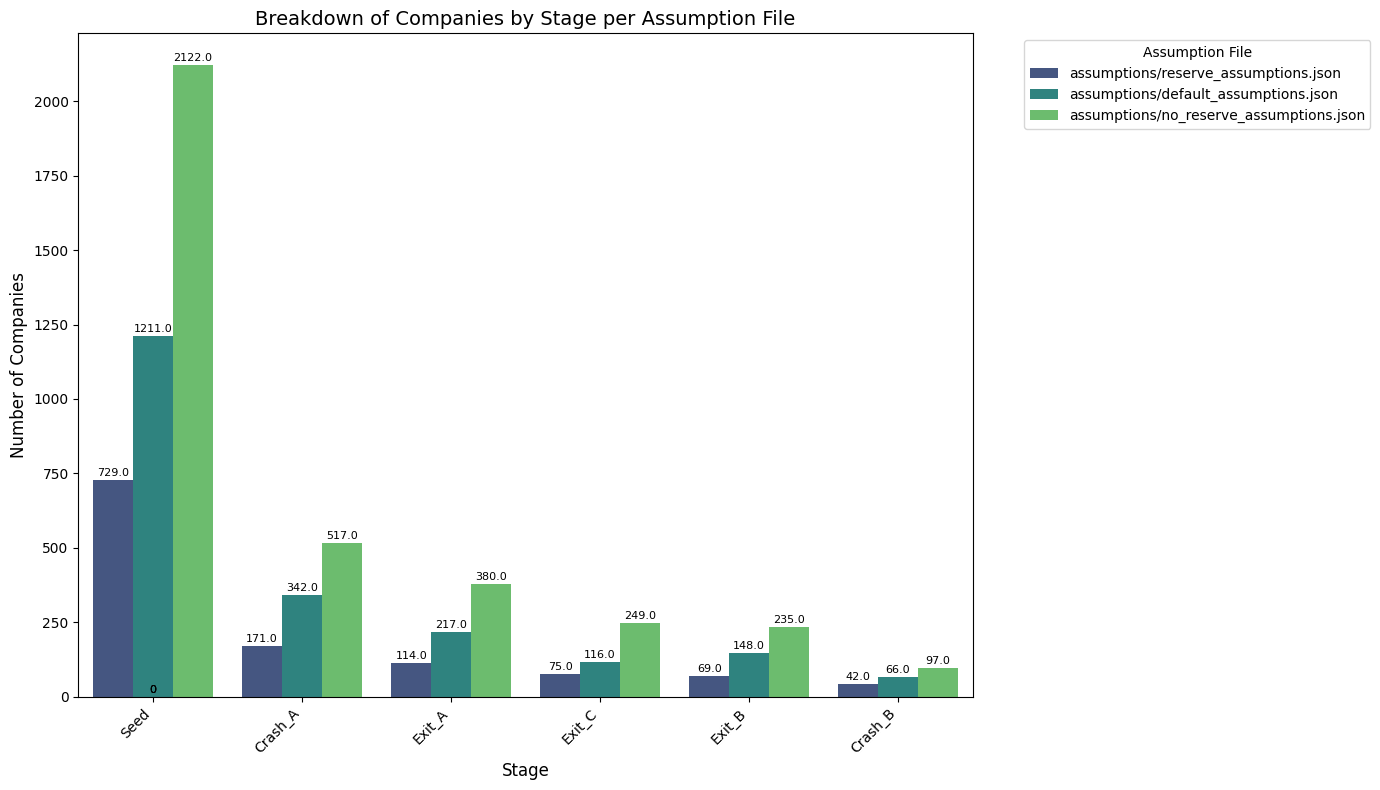

In [ ]:
plot_data = []
for index, row in results_summary_df.iterrows():
    assumption_file = row['assumption_file']
    detailed_data = row['all_company_data']

    # Calculate stage counts for the current assumption file
    stage_counts = detailed_data['stage'].value_counts().reset_index()
    stage_counts.columns = ['Stage', 'Count']
    stage_counts['Assumption File'] = assumption_file
    plot_data.append(stage_counts)

# Concatenate the data for all assumption files
plot_df = pd.concat(plot_data, ignore_index=True)

# Create the grouped bar plot
plt.figure(figsize=(14, 8)) # Adjust figure size as needed for more bars
ax = sns.barplot(data=plot_df, x='Stage', y='Count', hue='Assumption File', palette='viridis')

plt.title('Breakdown of Companies by Stage per Assumption File', fontsize=14)
plt.xlabel('Stage', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Assumption File', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


for p in ax.patches:
     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

plt.show()

### Interpreting the Company Stage Breakdown Plot

This plot shows the number of companies invested broken down by the highest stage they reached (Seed, A, B, C, Exit, Crash) across all simulation runs, grouped by the assumption file used.

*   **Bars for each stage:** Each group of bars represents a specific stage.
*   **Bars within each group:** Within each stage group, there is a bar for each assumption file you selected, indicating the total count of companies that ended in that stage for all simulations run with that assumption set.
*   **Comparison:** By comparing the heights of the bars within a stage group, you can see how different assumptions influenced the number of companies at each highest stage reached.

Remember the data is shown as total for all simulations that were run (NUM_SIMS) for each assumption set.

Use this plot to understand the impact of your assumptions on the overall distribution of portfolio outcomes.

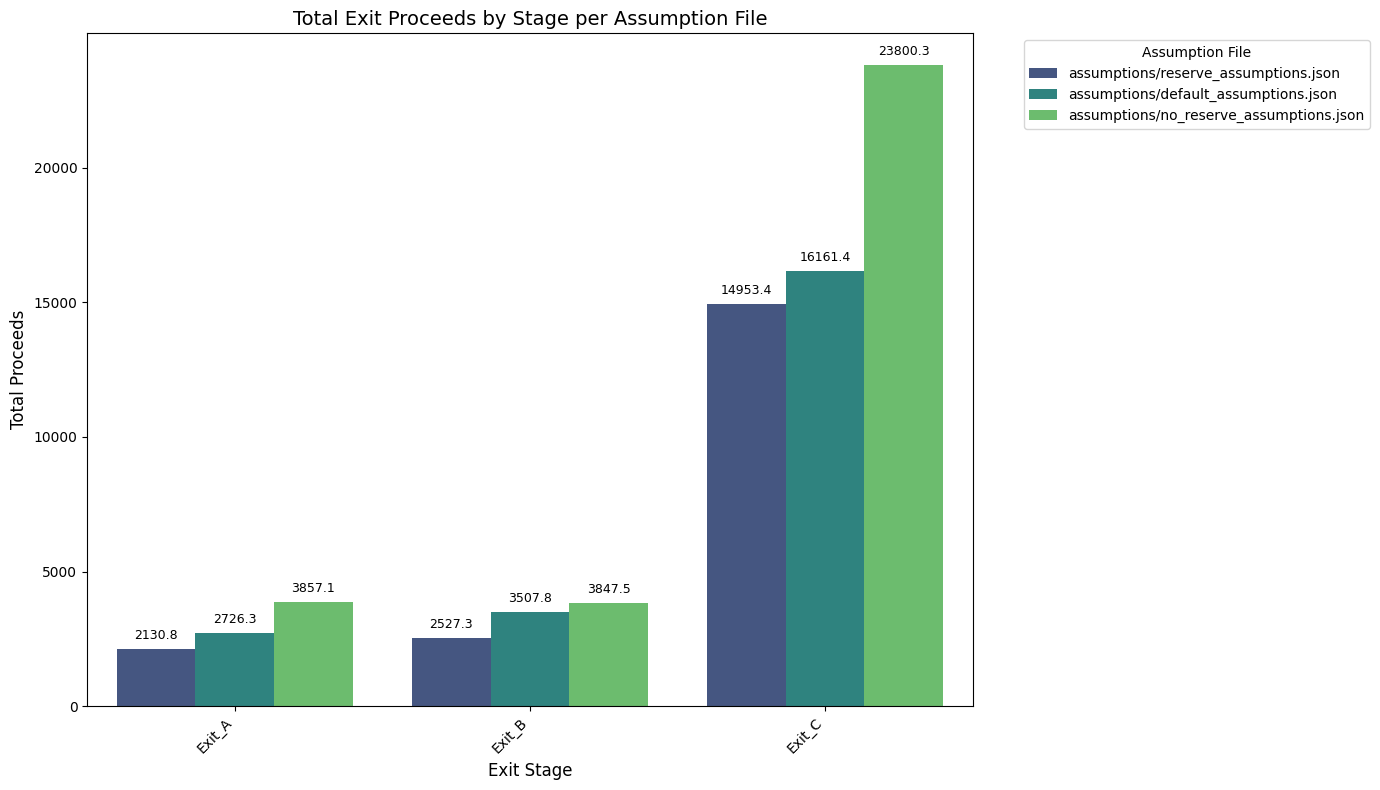

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'results_summary_df' DataFrame exists from the simulation cell's execution,
# and it contains the 'all_company_data' column.

# Prepare data for grouped bar plot of exit proceeds
plot_data_proceeds = []
for index, row in results_summary_df.iterrows():
    assumption_file = row['assumption_file']
    detailed_data = row['all_company_data']

    # Filter for companies that have exited (proceeds > 0) and group by stage
    exit_proceeds_by_stage = detailed_data[detailed_data['proceeds'] > 0].groupby('stage')['proceeds'].sum().reset_index()
    exit_proceeds_by_stage.columns = ['Exit Stage', 'Total Proceeds'] # Rename columns
    exit_proceeds_by_stage['Assumption File'] = assumption_file # Add assumption file column
    plot_data_proceeds.append(exit_proceeds_by_stage)

# Concatenate the data for all assumption files
plot_df_proceeds = pd.concat(plot_data_proceeds, ignore_index=True)

# Create the grouped bar plot for exit proceeds
plt.figure(figsize=(14, 8)) # Adjust figure size as needed
ax = sns.barplot(data=plot_df_proceeds, x='Exit Stage', y='Total Proceeds', hue='Assumption File', palette='viridis')

plt.title('Total Exit Proceeds by Stage per Assumption File', fontsize=14)
plt.xlabel('Exit Stage', fontsize=12)
plt.ylabel('Total Proceeds', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Assumption File', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add data labels (optional, can make crowded)
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 1e-9:
         ax.annotate(f'{height:.1f}', # Display with one decimal place
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     xytext=(0, 5),
                     textcoords='offset points',
                     fontsize=9,
                     color='black')


plt.show()

### Interpreting the Average Exit Proceeds Plot

This plot visualizes the *average* amount of proceeds generated from exited companies at each stage (Exit\_A, Exit\_B, Exit\_C), calculated per simulation run and grouped by assumption file.

*   **Focus on Exits:** This plot only includes stages where a liquidity event (exit) occurred.
*   **Average per Simulation:** The height of each bar represents the average total proceeds from companies exiting at that stage, averaged across all `NUM_SIMS` simulations for a given assumption file.
*   **Financial Impact:** This plot helps you understand which assumption sets lead to higher expected financial returns from exits at different stages.
*   **Comparison:** Compare the bar heights for the same exit stage across different assumption files to see which assumptions resulted in higher average payouts from those exits.

Consider this plot alongside the stage breakdown plot to understand both the quantity and the financial value of exits under different scenarios.

#Extra cells (appendix)

In [ ]:
# --------------------------- run sims for last simulation file -----------------------------
metrics = []
last_df = None

all_company_data = []

for sim in range(NUM_SIMS):
    moic, tvpi, irr_val, out_df = simulate_once()
    out_df["sim_id"] = sim
    all_company_data.append(out_df)
    metrics.append((moic, tvpi, irr_val))
    last_df = out_df

all_df = pd.concat(all_company_data, ignore_index=True)
all_df.to_csv("simulation_results.csv", index=False)

metrics = np.array(metrics)
metrics_df = pd.DataFrame(metrics, columns=["MOIC", "TVPI", "IRR"])
metrics_df.to_csv("fund_metrics_per_simulation.csv", index=False)


print(f"Mean MOIC over {NUM_SIMS} runs: {metrics[:,0].mean():.2f}× | Std dev: {metrics[:,0].std():.2f}×")
print(f"Mean TVPI over {NUM_SIMS} runs: {metrics[:,1].mean():.2f}× | Std dev: {metrics[:,1].std():.2f}×")
print(f"Mean IRR  over {NUM_SIMS} runs: {metrics[:,2].mean():.2%} | Std dev: {metrics[:,2].std():.2%}")
print(f"Assumptions set: {PROB} {MULT}")

all_df


Mean MOIC over 100 runs: 3.67× | Std dev: 1.80×
Mean TVPI over 100 runs: 3.12× | Std dev: 1.53×
Mean IRR  over 100 runs: 18.08% | Std dev: 8.90%
Assumptions set: {'seed_to_A': 0.4, 'A_to_B': 0.4, 'A_to_exit': 0.25, 'A_to_crash': 0.35, 'B_to_C': 0.4, 'B_to_exit': 0.4, 'B_to_crash': 0.2} {'Seed_to_A': 3.8, 'A_to_B': 2.0, 'A_to_exit': 1.15, 'B_to_C': 2.0, 'B_to_exit': 1.15, 'C_to_exit_low': 1.15, 'C_to_exit_high': 7.0}


,id,stage,invested,ownership,val_post,val_A,val_B,val_C,exit_val,proceeds,last_year,reached_A,reached_B,reached_C,exit_stage,sim_id
0,1,Exit_C,4.485,0.0640,437.00,NaN,NaN,NaN,1488.204965,95.245118,8,False,False,False,None,0
1,2,Exit_B,2.300,0.0640,218.50,NaN,NaN,NaN,251.275000,16.081600,6,False,False,False,None,0
2,3,Seed,2.300,0.1000,23.00,NaN,NaN,NaN,0.000000,0.000000,0,False,False,False,None,0
3,4,Exit_C,2.300,0.0512,437.00,NaN,NaN,NaN,622.204494,31.856870,8,False,False,False,None,0
4,5,Seed,2.300,0.1000,23.00,NaN,NaN,NaN,0.000000,0.000000,0,False,False,False,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,32,Seed,2.300,0.1000,23.00,NaN,NaN,NaN,0.000000,0.000000,0,False,False,False,None,99
3596,33,Seed,2.300,0.1000,23.00,NaN,NaN,NaN,0.000000,0.000000,0,False,False,False,None,99
3597,34,Seed,2.300,0.1000,23.00,NaN,NaN,NaN,0.000000,0.000000,0,False,False,False,None,99
3598,35,Exit_A,2.300,0.0800,109.25,NaN,NaN,NaN,125.637500,10.051000,4,False,False,False,None,99
